<a href="https://colab.research.google.com/github/pockerman/hidden_markov_modeling/blob/master/stories/story_15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Story 27


### Region 1 [1000000-20000000] chr2

In [1]:
import sys
sys.path.append("../")

In [2]:
import numpy as np
from pomegranate import *
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from helpers import read_configuration_file, INFO, WARNING
from train import load_regions
from hmm_helpers import build_hmm
from helpers import WindowType
from preprocess_utils import get_distributions_list_from_names as get_dist_list
from region import Region

In [4]:
from notebooks_helpers import filter_viterbi_path
from notebooks_helpers import save_segments
from notebooks_helpers import load_data_file
from notebooks_helpers import get_start_end_segment
from notebooks_helpers import make_data_array
from notebooks_helpers import gmm_clustering
from notebooks_helpers import create_viterbi_path
from notebooks_helpers import create_states
from notebooks_helpers import create_tuf_state
from notebooks_helpers import get_states_counter
from notebooks_helpers import plot_hmm_states_to_labels
from notebooks_helpers import plot_hmm_label_state
from notebooks_helpers import plot_hmm_cluster_contours

In [5]:
sns.set(color_codes=True)

Apply ```HMM_Model_9.json``` in region ```region_0_REGION_1_CHR_2_MEAN_CUTOFF.txt``` [1000000-20000000]

Orphan state HMM_Model-start removed due to no edges                             leading to it
Orphan state HMM_Model-end removed due to no edges                             leading to it


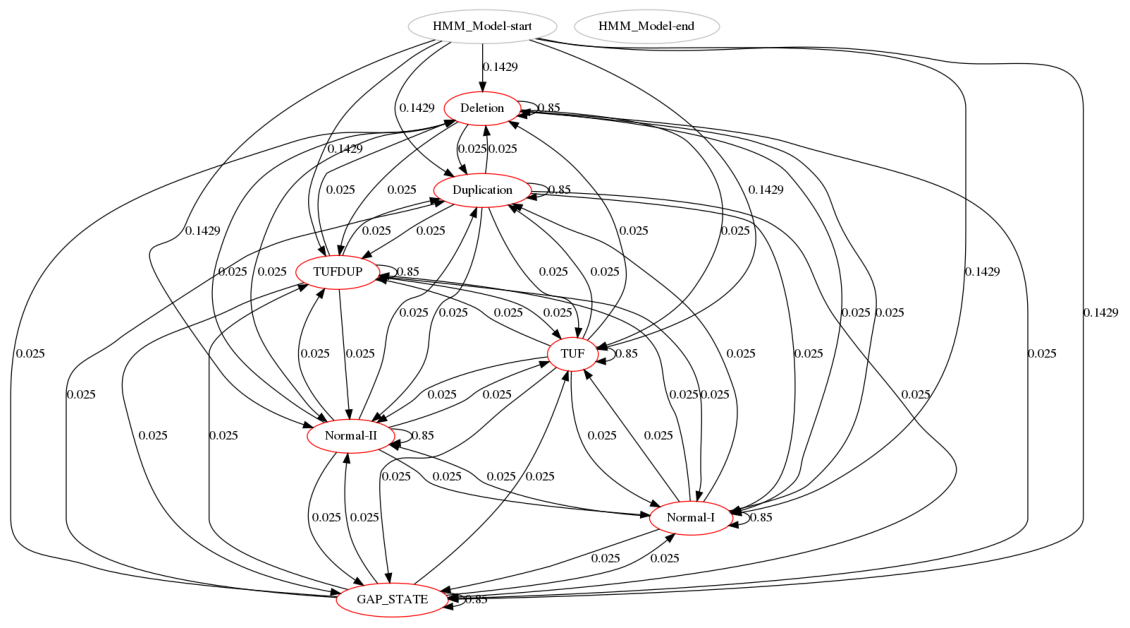

In [6]:
# load the configuration
configuration = read_configuration_file("../config.json")
hmm_config = configuration["HMM"]
hmm_filename = "HMM_Model_9.json"
hmm_model = build_hmm(hmm_file=hmm_filename)
# visualize the model we just trained
plt.figure( figsize=(20,18) )
hmm_model.plot()
plt.show()

In [7]:
# load the region we want to use for prediction
region_name = "region_0_REGION_1_CHR_2_MEAN_CUTOFF.txt"
region_file = "/home/alex/qi3/hidden_markov_modeling/data/" + region_name 
region = Region.load(filename=region_file)
region.check_windows_sanity()
mixed_windows = region.get_mixed_windows()

# load a sequence including the gaps
sequence = region.get_region_as_rd_mean_sequences_with_windows(size=None,
                                                               window_type=WindowType.from_string(hmm_config["train_windowtype"]),
                                                                n_seqs=hmm_config["train_n_sequences_per_source"],
                                                                exclude_gaps=False)

print("Sequence length: ", len(sequence))

INFO: Loading region from file: /home/alex/qi3/hidden_markov_modeling/data/region_0_REGION_1_CHR_2_MEAN_CUTOFF.txt
Sequence length:  189993


In [8]:
filename="viterbi_path_" + region_name
viterbi_path, observations, sequence_viterbi_state = create_viterbi_path(sequence=sequence, 
                                                                         hmm_model=hmm_model, filename=filename)

Observation length:  189993
Done. Execution time 0.6714232030026324 secs
Log-probability of ML Viterbi path:  -1279004.1706332986
Viterbi path length:  189994
There should be 11 gaps


In [11]:
# extract the tuf + Deletion + tuf
tuf_delete_tuf = filter_viterbi_path(path=viterbi_path[1][1:],
                                    wstate='TUF', limit_state='Deletion',
                                    min_subsequence=1)

print("Length of TUF+DELETION+TUF state: ", len(tuf_delete_tuf))

segments = get_start_end_segment(tuf_delete_tuf, sequence)

filename="tuf_delete_tuf_" + region_name
save_segments(segments=segments, chromosome='chr1', filename=filename)

Length of path  189993
Length of TUF+DELETION+TUF state:  2556


In [12]:
wga_obs = []
no_wga_obs = []
no_gaps_obs = []

for obs in observations:
    
    # do not account for gaps
    if obs != (-999.0, -999.0):
        wga_obs.append(obs[0])
        no_wga_obs.append(obs[1])
        no_gaps_obs.append((obs[1], obs[0]))
 
print("Length of WGA Observations: ", len(wga_obs))
print("Encountered gaps: ", len(observations) - len(wga_obs))
nbins = 80

Length of WGA Observations:  189982
Encountered gaps:  11


In [13]:
states_counter = {"Duplication": 0, "Normal-I": 0, "Normal-II":0, 
                  "Deletion": 0, "Single-Deletion": 0, "TUF": 0,
                  "GAP_STATE": 0, "GAP_STATE_INCORRECT":0, 'TUFDUP':0}

states_counter, state_data = get_states_counter(states_counter=states_counter,
                                   observations=observations,
                                   sequence_viterbi_state=sequence_viterbi_state)
print(states_counter) 

{'Duplication': 99, 'Normal-I': 136024, 'Normal-II': 49032, 'Deletion': 258, 'Single-Deletion': 0, 'TUF': 4568, 'GAP_STATE': 11, 'GAP_STATE_INCORRECT': 0, 'TUFDUP': 1}


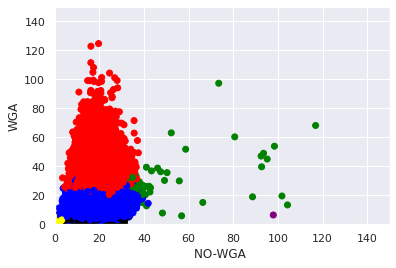

HMM labels color:  {'blue': [1, 136024], 'black': [5, 4568], 'red': [2, 49032], 'yellow': [3, 258], 'green': [0, 99], 'purple': [6, 1]}


In [14]:
hmm_states_to_labels = {"Duplication": 0, "Normal-I": 1, "Normal-II":2, 
                        "Deletion": 3, "Single-Deletion": 4, "TUF": 5, "TUFDUP":6}

color_comp_assoc_hmm, hmm_states_to_labels, hmm_labels = \
plot_hmm_states_to_labels(hmm_states_to_labels=hmm_states_to_labels,
                          observations=observations, 
                          sequence_viterbi_state=sequence_viterbi_state, 
                          no_wga_obs=no_wga_obs, wga_obs=wga_obs, 
                          xlim=(0.0, 150.), ylim=(0.0, 150.0))
print("HMM labels color: ", color_comp_assoc_hmm)

In [15]:
for state in state_data:
    print("State: ", state)
    
    if state == 'Single-Deletion' or state == 'GAP_STATE_INCORRECT':
        continue
    
    print("WGA mean/var: ", np.mean(state_data[state][0]), np.var(state_data[state][0]))
    print("NO-WGA mean/var: ", np.mean(state_data[state][1]), np.var(state_data[state][1]))

State:  Duplication
WGA mean/var:  27.63474747474747 155.77612392613
NO-WGA mean/var:  42.981212121212124 391.60911166207524
State:  Normal-I
WGA mean/var:  16.11228467035229 26.405644229643265
NO-WGA mean/var:  18.27541228018585 20.95298066428959
State:  Normal-II
WGA mean/var:  31.590971202480016 69.19101078788012
NO-WGA mean/var:  19.266800048947626 19.026346384558654
State:  Deletion
WGA mean/var:  1.0318604651162793 1.669868631692807
NO-WGA mean/var:  2.034108527131783 1.9669172285319392
State:  Single-Deletion
State:  TUF
WGA mean/var:  2.416464535901926 2.6558618218596357
NO-WGA mean/var:  14.983121716287215 23.758464028967982
State:  GAP_STATE
WGA mean/var:  -999.0 0.0
NO-WGA mean/var:  -999.0 0.0
State:  GAP_STATE_INCORRECT
State:  TUFDUP
WGA mean/var:  6.42 0.0
NO-WGA mean/var:  97.94 0.0


State:  Duplication
Length: 99


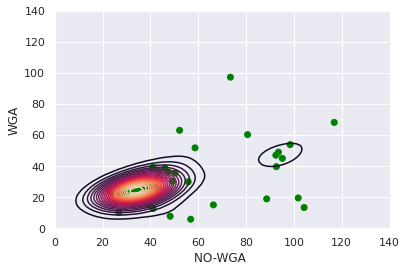

State:  Normal-I
Length: 136024


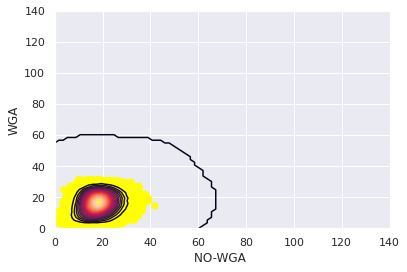

State:  Normal-II
Length: 49032


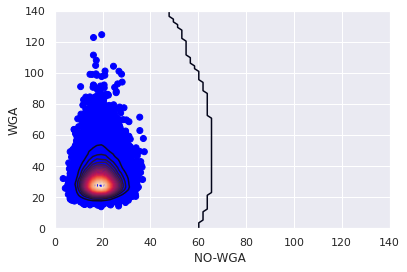

State:  Deletion
Length: 258


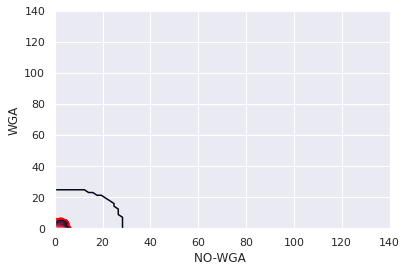

State:  Single-Deletion
For state: Single-Deletion could not plot empty observations
State:  TUF
Length: 4568


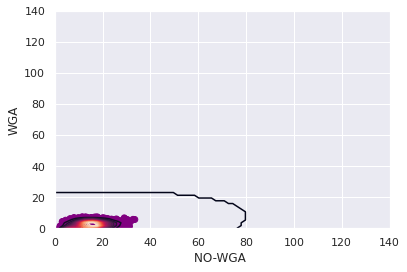

State:  TUFDUP
Length: 1


/home/alex/.local/lib/python3.6/site-packages/scipy/stats/kde.py:567: RuntimeWarning: Degrees of freedom <= 0 for slice
  aweights=self.weights))
/home/alex/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/alex/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


ValueError: array must not contain infs or NaNs

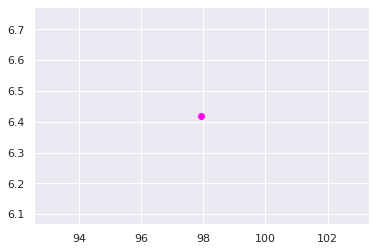

In [15]:
plot_hmm_label_state(hmm_states_to_labels=hmm_states_to_labels, hmm_labels=hmm_labels, 
                     no_wga_obs=no_wga_obs, wga_obs=wga_obs, nbins=80, xlim=(0.0, 140.),ylim=(0.0, 140.))

State:  Deletion
[[0.970271600267186, 0.958137372653406], [[1.1036072543648185, 0.0], [0.0, 1.1932036611641303]]]
State:  Duplication
[[24.283621138294365, 55.0], [[39.473393085057296, 0.0], [0.0, 71.53462337717849]]]
State:  Normal-I
[[13.750290519035646, 16.65535114027298], [[19.019257854346822, 0.0], [0.0, 31.488140792022595]]]
State:  Normal-II
[[40.0, 19.641842481040367], [[52.49115328954019, 0.0], [0.0, 19.606180750829882]]]
State:  TUF
[[1.7345118994138116, 14.220278071386755], [[1.9260086547849433, 0.0], [0.0, 15.655595281606255]]]
[[1.7345118994138116, 40.0], [[1.9260086547849433, 0.0], [0.0, 28.60670595671783]]]
Weights found:  [-0.69314718 -0.69314718]
Weights:  [0.5 0.5]
State:  TUFDUP
[[1.7345118994138116, 85.0], [[1.9260086547849433, 0.0], [0.0, 93.36225933227568]]]
state:  TUF
state:  Deletion
state:  Duplication
state:  Normal-I
state:  Normal-II
state:  TUFDUP


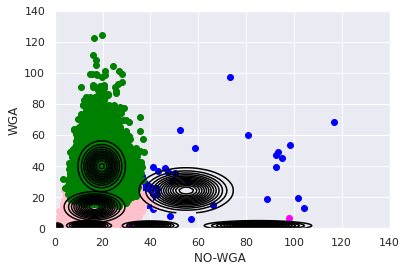

In [16]:
obs_state = {}

for state in hmm_states_to_labels:
    obs_state[state] = []

for i, obs in enumerate(observations):
        if obs != (-999.0, -999.0):
            viterbi_state = sequence_viterbi_state[i][1]
            obs_state[viterbi_state].append(obs)
            
states = hmm_model.states

state_vars = {}

for state in states:
    
    if state.name in hmm_states_to_labels:
        
        print("State: ", state.name)
        
        if state.distribution.name == "MultivariateGaussianDistribution":
            print(state.distribution.parameters)
            
            state_vars[state.name] = state.distribution.parameters
            
        elif state.name == 'TUF':
            
            state_vars[state.name] = {}
           
            for i, comp in enumerate(state.distribution.distributions):
                state_vars[state.name]["comp"+str(i)] = comp.parameters
                print(comp.parameters)
            weights = state.distribution.weights
            print("Weights found: ", weights)
            state_vars[state.name]["weights"] = np.exp(weights) 
            print("Weights: ", state_vars[state.name]["weights"])


state_colors={'TUF':"purple", "Deletion":"red",
                'Duplication':"blue", "Normal-I":"pink",
                "Normal-II":"green",
             'TUFDUP':'magenta'}

state_min_max = {'TUF':{'min_x': 0.0, 'max_x':140.0, 'min_y': 0.0, 'max_y':10.0},
                 'TUFDUP':{'min_x': 40.0, 'max_x':140.0, 'min_y': 0.0, 'max_y':10.0},
                 'Deletion':{'min_x': 0.0, 'max_x':10.0, 'min_y': 0.0, 'max_y':10.0},
                 'Normal-II':{'min_x': 0.0, 'max_x':45.0, 'min_y': 0.0, 'max_y':140.0},
                 'Normal-I':{'min_x': 0.0, 'max_x':45.0, 'min_y': 0.0, 'max_y':35.0},
                 'Duplication':{'min_x': 20.0, 'max_x':140.0, 'min_y': 10.0, 'max_y':140.0}}

plot_hmm_cluster_contours(state_colors=state_colors, state_vars=state_vars, 
                          obs_state=obs_state, nbins=80, ncontours=14, state_min_max=state_min_max)